# 한글

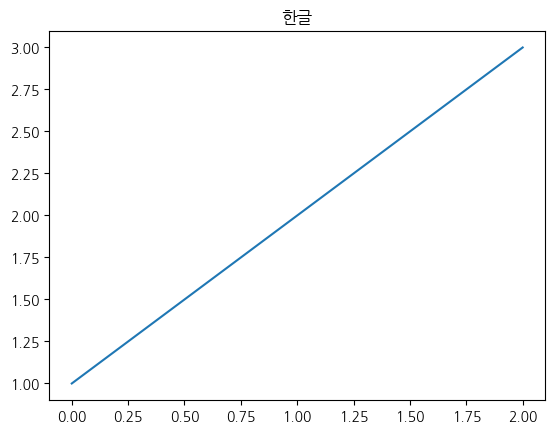

In [1]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

# 최종 비교용 모델

## 수정(참고내용)

In [2]:
import pandas as pd
# CSV 파일 불러오기
Final_D = pd.read_csv('../data/for_ship_model.csv') 

In [3]:
Final_D.columns

Index(['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', '호출부호', '접안_대기시간_분',
       '계선장소명', '선박용도', 'Service_Time_분', '대기율', '총톤수', '재화중량톤수',
       '선박제원(총길이, m)', '선박제원(너비, m)', '만재흘수(m)', '깊이(m)', '길이1(m)', '풍속(m/s)',
       '풍향(deg)', 'GUST풍속(m/s)', '현지기압(hPa)', '습도(%)', '기온(°C)', '수온(°C)',
       '최대파고(m)', '유의파고(m)', '평균파고(m)', '파주기(sec)', '파향(deg)', '이전_입항선박수',
       '연도별_선석점유율', '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간', '선박_연평균_대기시간',
       '호출부호_encoded', '계선장소명_encoded', '선박용도_encoded'],
      dtype='object')

In [4]:
Final_D.columns = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', '호출부호', '접안_대기시간_분',
       '계선장소명', '선박용도', 'Service_Time_분', '대기율', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '파향', '이전_입항선박수',
       '연도별_선석점유율', '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간', '선박_연평균_대기시간',
       '호출부호_encoded', '계선장소명_encoded', '선박용도_encoded']

x_cols = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour',
       'Service_Time_분', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
        '파주기', '파향', '이전_입항선박수','시설연평균_재화중량톤수', 
        '연평균_총입항건수', '선박_연평균_서비스시간', '계선장소명_encoded', '선박용도_encoded']

## 모델링

0:	learn: 1106.8360014	test: 1144.8848160	best: 1144.8848160 (0)	total: 229ms	remaining: 1m 54s
100:	learn: 760.5461965	test: 1086.5302148	best: 1082.9973669 (56)	total: 4.96s	remaining: 19.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1082.997367
bestIteration = 56

Shrink model to first 57 iterations.
0:	learn: 1117.6749687	test: 1046.8250270	best: 1046.8250270 (0)	total: 48.9ms	remaining: 24.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 998.4840383
bestIteration = 49

Shrink model to first 50 iterations.
0:	learn: 1116.2085470	test: 1052.0252235	best: 1052.0252235 (0)	total: 50.4ms	remaining: 25.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 993.1363843
bestIteration = 25

Shrink model to first 26 iterations.
0:	learn: 1108.3114635	test: 1141.1745534	best: 1141.1745534 (0)	total: 46.5ms	remaining: 23.2s
100:	learn: 748.6679481	test: 1077.8950768	best: 1077.8950768 (100)	total: 5.11s	remaining: 20.2s
Stopped by overf

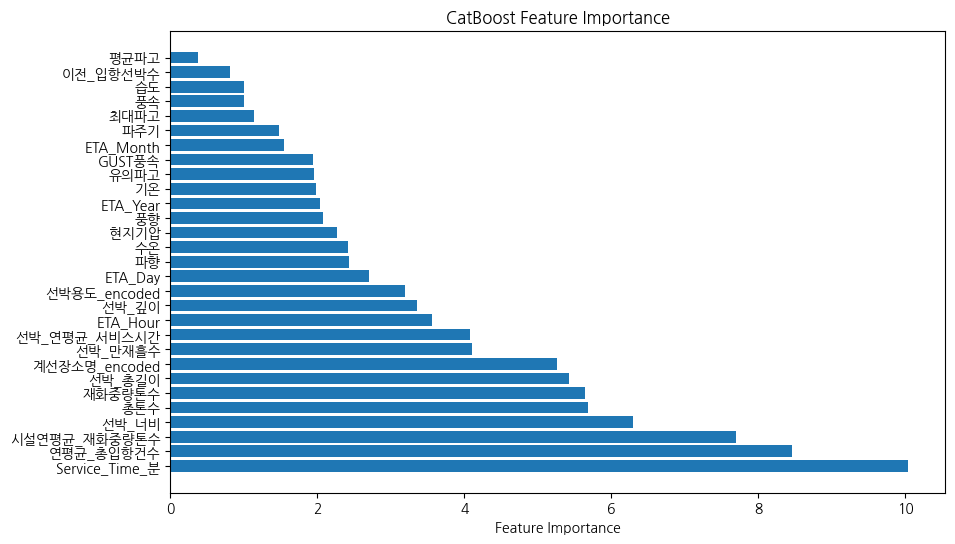

In [5]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error  # 추가
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# 특성과 타겟 분리
X = Final_D[x_cols]
y = Final_D['접안_대기시간_분']

# KFold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=12)

# 성능 지표 초기화
rmse_scores = []
mae_scores = []  # 추가

# KFold를 이용한 교차 검증
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # CatBoost 모델 생성 및 훈련
    model = CatBoostRegressor(iterations=500,
                              learning_rate=0.3,
                              depth=10, 
                              loss_function='RMSE',
                              verbose=100)
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=100)

    # 예측
    y_pred = model.predict(X_val)

    # 평가 지표 계산
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mae = mean_absolute_error(y_val, y_pred)  # 추가

    # 성능 지표 저장
    rmse_scores.append(rmse)
    mae_scores.append(mae)  # 추가

# 교차 검증 결과 출력
print(f'Average RMSE: {sum(rmse_scores) / len(rmse_scores)}')
print(f'Average MAE: {sum(mae_scores) / len(mae_scores)}')  # 추가

# 피처 임포턴스 시각화
feature_importance = model.get_feature_importance()
feature_names = X.columns

feature_importance_dict = dict(zip(feature_names, feature_importance))

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_feature_importance = zip(*sorted_feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_feature_importance, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()
